In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

# Swap that to True if you want to invert nucls
INVERT = True
#Change to true to filter mutspecs by num of total muts and num of mut types
FILTER = True

In [2]:
def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

def filter(mutspec12, meta_df):
    #removing species with less than 15 total mutations - might need to bump up for all insects (do not do it for termites)
    mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
    less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > 15].index)['Species'].to_list()
    for sp in less_than_15_total_muts:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)
    
    #removing species with less than 4 mutation types - might need to bump up for all insects (do not do it for termites)
    species = mutspec12['Species'].drop_duplicates().to_list()
    obsnum_values = mutspec12['ObsNum'].to_list()
    chopped_obsnum =  list(chop(obsnum_values, 12))
    
    species_and_obsnum = {}
    for i in range(len(species)):
        species_and_obsnum[species[i]] = chopped_obsnum[i]
    
    less_than_4_mut_types = []
    for sp, obsnum_list in species_and_obsnum.items():
        if obsnum_list.count(0) > 8: # 8 for less than 4 mut types, 4 is less than 8 mut types, 2 is less than 10 mut types, 0 for less than 12 mut type, i.e. all mut types are present
            less_than_4_mut_types.append(sp)
    
    for sp in less_than_4_mut_types:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

    return mutspec12, meta_df

def inverter(mutspec12):
    # inverts nucls for ms12, needs to be run only once. DEW IT :3
    a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
    t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
    g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
    c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

    a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
    a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
    a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

    t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
    t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
    t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

    g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
    g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
    g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

    c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
    c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
    c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

    mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])
    return mutspec12

In [3]:
blattodea_meta = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/msMetaData.tsv', 
                             sep='\t')
cock_ter_mutspec12 = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/ms12syn_internal_iqtree.tsv',
                                 sep='\t')

if INVERT == True:
    cock_ter_mutspec12 = inverter(cock_ter_mutspec12)
if FILTER == True:
    cock_ter_mutspec12, blattodea_meta = filter(cock_ter_mutspec12, blattodea_meta)

terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Hodotermitidae'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Corydiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blaberidae'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

cocks_mutspec12 = []
for sp in cocks_meta['Species']:
    cocks_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
cocks_mutspec12 = pd.concat(cocks_mutspec12)

terms_mutspec12 = []
for sp in terms_meta['Species']:
    terms_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
terms_mutspec12 = pd.concat(terms_mutspec12)

In [4]:
coda = CodonAnnotation(2)

nucls = list('ACGT')
i = 1
data = []
for cdn1 in possible_codons:
    aa1 = coda.translate_codon(cdn1)
    for pic in range(3):
        nuc1 = cdn1[pic]
        for nuc2 in nucls:
            if nuc1 == nuc2:
                continue
            cdn2 = list(cdn1)
            cdn2[pic] = nuc2
            cdn2 = ''.join(cdn2)
            aa2 = coda.translate_codon(cdn2)
            is_syn = aa1 == aa2
            sbs = f'{nuc1}>{nuc2}'
            data.append((pic, cdn1, cdn2, aa1, aa2, is_syn, sbs))
            i += 1
df_changes = pd.DataFrame(data, columns=['pic', 'cdn1', 'cdn2', 'aa1', 'aa2', 'is_syn', 'sbs'])

df_changes_flt = df_changes[(df_changes.aa1 != '*') & (df_changes.aa2 != '*')].copy()

In [5]:
df_changes_flt

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
0,0,AAA,CAA,K,Q,False,A>C
1,0,AAA,GAA,K,E,False,A>G
3,1,AAA,ACA,K,T,False,A>C
5,1,AAA,ATA,K,M,False,A>T
6,2,AAA,AAC,K,N,False,A>C
...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C
572,1,TTT,TGT,F,C,False,T>G
573,2,TTT,TTA,F,L,False,T>A
574,2,TTT,TTC,F,F,True,T>C


In [6]:
alphabet = 'ACGT'

def nuc_spectrum_to_matrix(spec):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    M = np.zeros((4,4))
    for i1,n1 in enumerate(alphabet):
        for i2,n2 in enumerate(alphabet):
            if n1!=n2:
                M[i2,i1] = spec[f"{n1}>{n2}"]
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


def aa_spectrum_to_matrix(aa_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(aa_alphabet)
    M = np.zeros((n, n))
    for i1,aa1 in enumerate(aa_alphabet):
        for i2,aa2 in enumerate(aa_alphabet):
            if aa1!=aa2:
                val = aa_sbs[(aa1, aa2)] if (aa1, aa2) in aa_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def cdn_spectrum_to_matrix(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def get_equilibrium_probabilities(M):
    evals, evecs = np.linalg.eig(M)
    # find zero eigenvalue
    ii = np.argmin(np.abs(evals))
    assert np.abs(evals[ii])<1e-10
    # pull out corresponding eigenvector, return normalized to sum_i p_i = 1
    p = evecs[:,ii]
    return p/p.sum()

In [7]:
cocks_mutspec12

,Species,Mut,ObsNum,ExpNum,MutSpec
201,Bundoksia_longissima,A>C,0.000000,32.77020,0.000000
197,Bundoksia_longissima,A>G,4.892390,104.16100,0.071294
196,Bundoksia_longissima,A>T,0.796214,32.77020,0.000000
198,Bundoksia_longissima,C>A,0.000000,3.91334,0.000000
203,Bundoksia_longissima,C>G,0.000000,3.91334,0.000000
...,...,...,...,...,...
308,Geoscapheus_dilatatus,G>C,0.000000,20.01260,0.000000
310,Geoscapheus_dilatatus,G>T,0.000000,20.01260,0.000000
301,Geoscapheus_dilatatus,T>A,6.328430,123.73500,0.045530
300,Geoscapheus_dilatatus,T>C,20.168700,229.35900,0.078280


In [8]:
terms_mutspec12

,Species,Mut,ObsNum,ExpNum,MutSpec
7,Reticulitermes_banyulensis,A>C,0.000000,16.30930,0.000000
4,Reticulitermes_banyulensis,A>G,5.490140,48.28200,0.250095
10,Reticulitermes_banyulensis,A>T,0.000000,16.30930,0.000000
9,Reticulitermes_banyulensis,C>A,0.000000,11.41120,0.000000
5,Reticulitermes_banyulensis,C>G,0.000000,11.41120,0.000000
3,Reticulitermes_banyulensis,C>T,5.136350,22.03450,0.512694
2,Reticulitermes_banyulensis,G>A,4.910730,78.08140,0.138326
11,Reticulitermes_banyulensis,G>C,0.000000,14.12300,0.000000
6,Reticulitermes_banyulensis,G>T,0.000000,14.12300,0.000000
1,Reticulitermes_banyulensis,T>A,0.973467,89.31860,0.023971


In [9]:
subs = ['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']

cocks_mean_ms = {}
terms_mean_ms = {}

for sub in subs:
    cocks_mean_ms[sub] = cocks_mutspec12[cocks_mutspec12['Mut'] == sub]['MutSpec'].mean()
    terms_mean_ms[sub] = terms_mutspec12[terms_mutspec12['Mut'] == sub]['MutSpec'].mean()

In [10]:
cocks_mean_ms

{'A>C': 0.00443670875,
 'A>G': 0.10837028750000001,
 'A>T': 0.018542562500000002,
 'C>A': 0.067486325,
 'C>G': 0.0,
 'C>T': 0.361836625,
 'G>A': 0.31095337500000003,
 'G>C': 0.0014752625,
 'G>T': 0.0387209375,
 'T>A': 0.03213165,
 'T>C': 0.0466535,
 'T>G': 0.0093928625}

In [11]:
terms_mean_ms

{'A>C': 0.0,
 'A>G': 0.32214625,
 'A>T': 0.0,
 'C>A': 0.017531275,
 'C>G': 0.0,
 'C>T': 0.37020875,
 'G>A': 0.18741225,
 'G>C': 0.0,
 'G>T': 0.029286675,
 'T>A': 0.0076997,
 'T>C': 0.0648304,
 'T>G': 0.0008849775}

In [12]:
cock_changes = df_changes.copy()
term_changes = df_changes.copy()

cock_changes['MutSpec'] = cock_changes['sbs'].map(cocks_mean_ms)
term_changes['MutSpec'] = term_changes['sbs'].map(terms_mean_ms)


In [13]:
cock_changes

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,MutSpec
0,0,AAA,CAA,K,Q,False,A>C,0.004437
1,0,AAA,GAA,K,E,False,A>G,0.108370
2,0,AAA,TAA,K,*,False,A>T,0.018543
3,1,AAA,ACA,K,T,False,A>C,0.004437
4,1,AAA,AGA,K,*,False,A>G,0.108370
...,...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C,0.046654
572,1,TTT,TGT,F,C,False,T>G,0.009393
573,2,TTT,TTA,F,L,False,T>A,0.032132
574,2,TTT,TTC,F,F,True,T>C,0.046654


In [14]:
term_changes

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,MutSpec
0,0,AAA,CAA,K,Q,False,A>C,0.000000
1,0,AAA,GAA,K,E,False,A>G,0.322146
2,0,AAA,TAA,K,*,False,A>T,0.000000
3,1,AAA,ACA,K,T,False,A>C,0.000000
4,1,AAA,AGA,K,*,False,A>G,0.322146
...,...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C,0.064830
572,1,TTT,TGT,F,C,False,T>G,0.000885
573,2,TTT,TTA,F,L,False,T>A,0.007700
574,2,TTT,TTC,F,F,True,T>C,0.064830


[0.46674388 0.04208787 0.15308779 0.33808046]


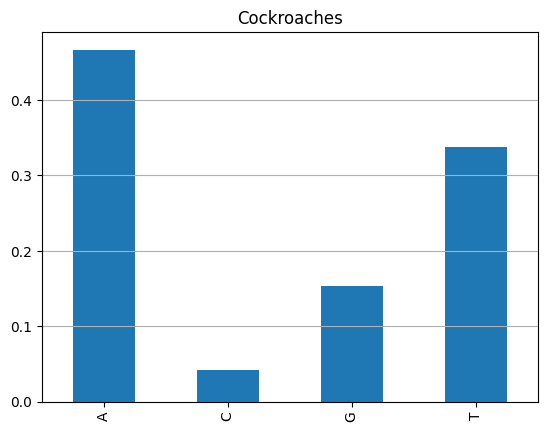

In [15]:
M = nuc_spectrum_to_matrix(cocks_mean_ms) # may use either rates or mutspect 
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
pd.Series(dict(zip(alphabet, eq_prob))).plot.bar()
# plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Cockroaches');

[0.14365108 0.09175905 0.215794   0.54879587]


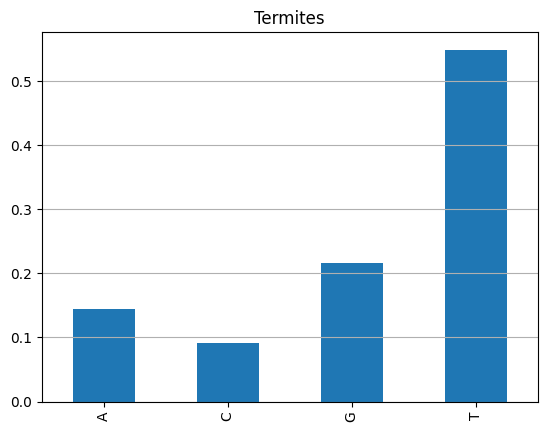

In [16]:
M = nuc_spectrum_to_matrix(terms_mean_ms) # may use either rates or mutspect 
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
pd.Series(dict(zip(alphabet, eq_prob))).plot.bar()
# plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Termites');

In [17]:
cdn_sbs = cock_changes.groupby(['cdn1', 'cdn2'])['MutSpec'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon)
eq_freqs.sort_values('freq')

/tmp/ipykernel_71506/1681272869.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


,cdn,freq,aa
21,CCC,0.000075,P
22,CCG,0.000271,P
25,CGC,0.000271,R
37,GCC,0.000271,A
53,TCC,0.000599,S
...,...,...,...
15,ATT,0.053348,I
12,ATA,0.073651,M
48,TAA,0.073651,*
3,AAT,0.073651,N


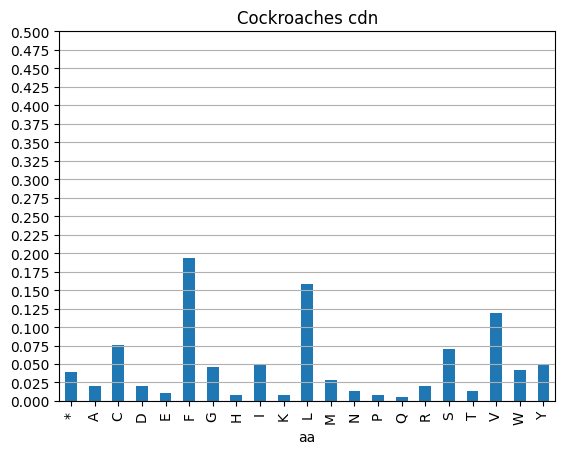

In [21]:
plt.yticks(np.linspace(0, 0.4, 17));
eq_freqs_aa_new = eq_freqs.groupby('aa').freq.sum()
eq_freqs_aa_new.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Cockroaches cdn');

In [19]:
cdn_sbs = term_changes.groupby(['cdn1', 'cdn2'])['MutSpec'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon)
eq_freqs.sort_values('freq')

/tmp/ipykernel_71506/3643108226.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


,cdn,freq,aa
21,CCC,0.000773,P
17,CAC,0.001210,H
20,CCA,0.001210,P
5,ACC,0.001210,T
37,GCC,0.001817,A
...,...,...,...
51,TAT,0.043264,Y
62,TTG,0.064992,L
47,GTT,0.064992,V
59,TGT,0.064992,C


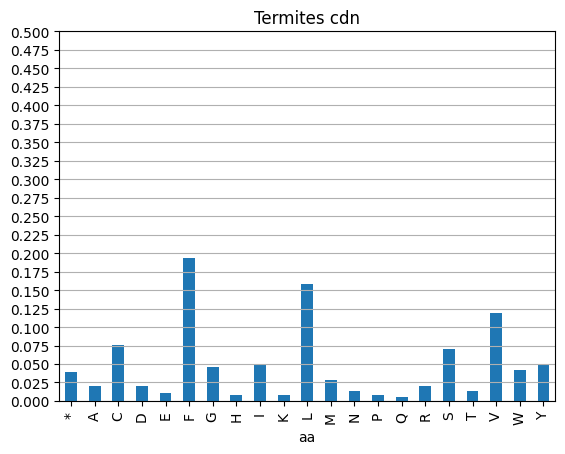

In [22]:
plt.yticks(np.linspace(0, 0.4, 17));
eq_freqs_aa_new = eq_freqs.groupby('aa').freq.sum()
eq_freqs_aa_new.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Termites cdn');